In [ ]:
# default_exp ranker

In [ ]:
from tensorflow import one_hot

In [ ]:
# export
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

import matplotlib.pyplot as plt

from dist_curve.transforms import getOptimalTransform

from sklearn.metrics import roc_auc_score

from tqdm.notebook import tqdm,trange

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

# from multiinstance.density_ratio_em import DensityRatioEM

from multiinstance.nnpu import getPosterior

from easydict import EasyDict
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Dense, Input, Subtract
from tensorflow.keras.models import Model
import numpy as np
import math

import pandas as pd
from tqdm.notebook import trange

In [ ]:
dg = GaussianMixtureDataGenerator(10,1,[0.8,.9],100,1000)

In [ ]:
[xPU,yPU,yPN] = dg.pu_data()

In [ ]:
# xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN)

xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN,test_size=.2)
yPUTrain= yPUTrain[:,0].astype(bool)
posTrain = xPUTrain[yPUTrain]
uTrain = xPUTrain[~yPUTrain]
posidxs = np.random.choice(np.arange(posTrain.shape[0]),size=uTrain.shape[0],replace=True)
xpos = posTrain[posidxs]
xPUTrain = np.concatenate((xpos,uTrain))
yPUTrain = np.concatenate((np.ones(uTrain.shape[0]),
                           np.zeros(uTrain.shape[0])))

In [ ]:
from sklearn.metrics import ndcg_score

# RankNet

In [ ]:
# export
class RankNet:
    def buildModel(self,input_shape):
        layers = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(64,activation="relu"),
            tf.keras.layers.Dense(1)
        ],name="dense_layers")
        inp1 = tf.keras.layers.Input(shape=(input_shape,),name="input_1")
        inp2 = tf.keras.layers.Input(shape=(input_shape,),name="input_2")
        score_1 = layers(inp1)
        score_2 = layers(inp2)
        score_diff = tf.keras.layers.Subtract()([score_1, score_2])
        prob = tf.keras.layers.Activation("sigmoid")(score_diff)
        self.model = tf.keras.models.Model(inputs=[inp1,inp2],outputs=prob)
        self.ranker = tf.keras.backend.function([inp1],[score_1])
        self.model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=tf.keras.losses.BinaryCrossentropy())

    def train(self,xPU,yPU,NIters=1000, batch_size=128,):
        skf = StratifiedKFold()
        ranks = np.zeros(xPU.shape[0])
        for trainIndices,valIndices in skf.split(xPU,yPU):
            xPUTrain,xPUVal,yPUTrain,yPUVal = xPU[trainIndices],xPU[valIndices],yPU[trainIndices],yPU[valIndices]
            ranks[valIndices] = self.trainFold(xPUTrain,xPUVal,yPUTrain,yPUVal,NIters,batch_size)
        print(roc_auc_score(yPU,ranks))
        return ranks

    def trainFold(self,xPUTrain,xPUVal,yPUTrain,yPUVal,NIters=10000, batch_size=128,):
        batchesPerEpoch = np.ceil(xPUTrain.shape[0] / batch_size).astype(int) # +/- rounding error
        self.buildModel(xPUTrain.shape[1])
        # Early stopping variables
        minvalLoss,patience = np.inf,0
        posTrain,unlabeledTrain = xPUTrain[yPUTrain],xPUTrain[~yPUTrain]
        posVal,unlabeledVal = xPUVal[yPUVal],xPUVal[~yPUVal]
        for iters in trange(NIters,leave=False):
            idxs1 = np.random.randint(0,high=posTrain.shape[0],size=batch_size)
            idxs2 = np.random.randint(0,high=unlabeledTrain.shape[0],size=batch_size)
            posInputs,unlabeledInputs = posTrain[idxs1],unlabeledTrain[idxs2]
            inputs = np.stack([posInputs,unlabeledInputs],axis=-1)
            b = np.random.binomial(1,.5,inputs.shape[0]).astype(bool)
            inputs[b] = inputs[b][...,[1,0]]
            inp1,inp2 = inputs[...,0], inputs[...,1]
            target = ~b
            trainLoss = self.model.train_on_batch([inp1,inp2],target)
            if not iters % batchesPerEpoch:
                i1 = np.random.choice(range(xPUVal.shape[0]),replace=False,
                                       size=int(xPUVal.shape[0] / 2))
                i2 = np.random.choice(list(set(range(xPUVal.shape[0])) - set(i1)),size=i1.shape,replace=True)
                inp1,inp2 = xPUVal[i1],xPUVal[i2]
                y1,y2 = yPUVal[i1],yPUVal[i2]
                target = y1 > y2
                valLoss = self.model.evaluate([inp1,inp2],target)
                scores = self.ranker(xPUVal)
                if valLoss < minvalLoss:
                    print("minvalLoss, ",valLoss)
                    minvalLoss = valLoss
                    patience = 0
                else:
                    patience += 1
                if patience == 15:
                    break
        return self.ranker(xPUVal)[0].ravel()


In [ ]:
ranker = RankNet()
ranker.train(xPU,yPU[:,0].astype(bool))

4/4 [==============================] - 0s 2ms/step - loss: 0.7057
minvalLoss,  0.7057119011878967
4/4 [==============================] - 0s 1ms/step - loss: 0.6908
minvalLoss,  0.690820574760437
4/4 [==============================] - 0s 1ms/step - loss: 0.6882
minvalLoss,  0.6881860494613647
4/4 [==============================] - 0s 1ms/step - loss: 0.6608
minvalLoss,  0.660796582698822
4/4 [==============================] - 0s 1ms/step - loss: 0.7175


4/4 [==============================] - 0s 2ms/step - loss: 0.7197
minvalLoss,  0.7197121381759644
4/4 [==============================] - 0s 1ms/step - loss: 0.7038
minvalLoss,  0.7037843465805054
4/4 [==============================] - 0s 2ms/step - loss: 0.6954
minvalLoss,  0.6953619122505188
4/4 [==============================] - 0s 2ms/step - loss: 0.6876
minvalLoss,  0.6876232028007507
4/4 [==============================] - 0s 1ms/step - loss: 0.6784
minvalLoss,  0.6783671975135803
4/4 [==============================] - 0s 1ms/step - loss: 0.6746
minvalLoss,  0.6745843291282654
4/4 [==============================] - 0s 1ms/step - loss: 0.6544
minvalLoss,  0.654448926448822
4/4 [==============================] - 0s 1ms/step - loss: 0.7431


4/4 [==============================] - 0s 1ms/step - loss: 0.7036
minvalLoss,  0.703574001789093
4/4 [==============================] - 0s 2ms/step - loss: 0.6924
minvalLoss,  0.692406952381134
4/4 [==============================] - 0s 1ms/step - loss: 0.6876
minvalLoss,  0.6875813603401184
4/4 [==============================] - 0s 1ms/step - loss: 0.6626
minvalLoss,  0.662632167339325
4/4 [==============================] - 0s 1ms/step - loss: 0.7341


4/4 [==============================] - 0s 1ms/step - loss: 0.6578
minvalLoss,  0.6578065752983093
4/4 [==============================] - 0s 2ms/step - loss: 0.6553
minvalLoss,  0.6552771925926208
4/4 [==============================] - 0s 2ms/step - loss: 0.6433
minvalLoss,  0.6433157920837402
4/4 [==============================] - 0s 1ms/step - loss: 0.6744


4/4 [==============================] - 0s 1ms/step - loss: 0.7594
minvalLoss,  0.7593696117401123
4/4 [==============================] - 0s 2ms/step - loss: 0.7260
minvalLoss,  0.7259723544120789
4/4 [==============================] - 0s 1ms/step - loss: 0.7200
minvalLoss,  0.7200474739074707
4/4 [==============================] - 0s 2ms/step - loss: 0.7091
minvalLoss,  0.7091053128242493
4/4 [==============================] - 0s 2ms/step - loss: 0.6533
minvalLoss,  0.6532502174377441
4/4 [==============================] - 0s 1ms/step - loss: 0.6961
0.59241


array([ 0.04753315, -0.02644825,  0.32925704, ..., -0.38464999,
       -1.59322953, -0.99549162])

In [ ]:
ndcg_score(np.asarray([dg.pu_posterior(xPUVal)]),np.asarray([ranker.ranker(xPUVal)[0].ravel()]))

0.891967591199035

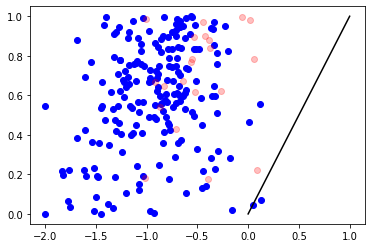

In [ ]:
plt.scatter(ranker.ranker(xPUVal[~yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[~yPUVal.ravel().astype(bool)]),color="blue")
plt.scatter(ranker.ranker(xPUVal[yPUVal.ravel().astype(bool)])[0],dg.pn_posterior_cc(xPUVal[yPUVal.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")

In [ ]:
import pandas as pd
from tqdm.notebook import trange

In [ ]:
# export ranker
class RankerNN(object):

    def __init__(self, input_size, hidden_layer_sizes=(100,), activation=('relu',), solver='adam'):
        """
        Parameters
        ----------
        input_size : integer
            Number of input features.
        hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
            The ith element represents the number of neurons in the ith
            hidden layer.
        activation : tuple, length = n_layers - 2, default ('relu',)
            The ith element represents activation function in the ith
            hidden layer.
        solver : {'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', adamax},
        default 'adam'
            The solver for weight optimization.
            - 'adam' refers to a stochastic gradient-based optimizer proposed
              by Kingma, Diederik, and Jimmy Ba
        """
        if len(hidden_layer_sizes) != len(activation):
            raise ValueError('hidden_layer_sizes and activation should have the same size.')
        self.model = self._build_model(input_size, hidden_layer_sizes, activation)
        self.model.compile(optimizer=solver, loss="binary_crossentropy")

    @staticmethod
    def _build_model(input_shape, hidden_layer_sizes, activation):
        """
        Build Keras Ranker NN model (Ranknet / LambdaRank NN).
        """
        # Neural network structure
        hidden_layers = []
        for i in range(len(hidden_layer_sizes)):
            hidden_layers.append(Dense(hidden_layer_sizes[i], activation=activation[i], name=str(activation[i]) + '_layer' + str(i)))
        h0 = Dense(1, activation='linear', name='Identity_layer')
        input1 = Input(shape=(input_shape,), name='Input_layer1')
        input2 = Input(shape=(input_shape,), name='Input_layer2')
        x1 = input1
        x2 = input2
        for i in range(len(hidden_layer_sizes)):
            x1 = hidden_layers[i](x1)
            x2 = hidden_layers[i](x2)
        x1 = h0(x1)
        x2 = h0(x2)
        # Subtract layer
        subtracted = Subtract(name='Subtract_layer')([x1, x2])
        # sigmoid
        out = Activation('sigmoid', name='Activation_layer')(subtracted)
        # build model
        model = Model(inputs=[input1, input2], outputs=out)
        return model

    @staticmethod
    def _CalcDCG(labels):
        sumdcg = 0.0
        for i in range(len(labels)):
            rel = labels[i]
            if rel != 0:
                sumdcg += ((2 ** rel) - 1) / math.log2(i + 2)
        return sumdcg

    def _fetch_qid_data(self, y, qid, eval_at=None):
        """Fetch indices, relevances, idcg and dcg for each query id.
        Parameters
        ----------
        y : array, shape (n_samples,)
            Target labels.
        qid: array, shape (n_samples,)
            Query id that represents the grouping of samples.
        eval_at: integer
            The rank postion to evaluate dcg and idcg.
        Returns
        -------
        qid2indices : array, shape (n_unique_qid,)
            Start index for each qid.
        qid2rel : array, shape (n_unique_qid,)
            A list of target labels (relevances) for each qid.
        qid2idcg: array, shape (n_unique_qid,)
            Calculated idcg@eval_at for each qid.
        qid2dcg: array, shape (n_unique_qid,)
            Calculated dcg@eval_at for each qid.
        """
        qid_unique, qid2indices, qid_inverse_indices = np.unique(qid, return_index=True, return_inverse=True)
        # get item releveance for each query id
        qid2rel = [[] for _ in range(len(qid_unique))]
        for i, qid_unique_index in enumerate(qid_inverse_indices):
            qid2rel[qid_unique_index].append(y[i])
        # get dcg, idcg for each query id @eval_at
        if eval_at:
            qid2dcg = [self._CalcDCG(qid2rel[i][:eval_at]) for i in range(len(qid_unique))]
            qid2idcg = [self._CalcDCG(sorted(qid2rel[i], reverse=True)[:eval_at]) for i in range(len(qid_unique))]
        else:
            qid2dcg = [self._CalcDCG(qid2rel[i]) for i in range(len(qid_unique))]
            qid2idcg = [self._CalcDCG(sorted(qid2rel[i], reverse=True)) for i in range(len(qid_unique))]
        return qid2indices, qid2rel, qid2idcg, qid2dcg


    def _transform_pairwise(self, X, y, qid):
        return None, None, None, None


    def fit(self, X, y, qid, batch_size=None, epochs=1, verbose=1, validation_split=0.0):
        """Transform data and fit model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Features.
        y : array, shape (n_samples,)
            Target labels.
        qid: array, shape (n_samples,)
            Query id that represents the grouping of samples.
        """
        X1_trans, X2_trans, y_trans, weight = self._transform_pairwise(X, y, qid)
        X1_trans = tf.convert_to_tensor(X1_trans)
        X2_trans = tf.convert_to_tensor(X2_trans)
        y_trans = tf.convert_to_tensor(y_trans)
        self.model.fit([X1_trans, X2_trans], y_trans, sample_weight=pd.Series(weight), batch_size=batch_size, epochs=epochs,
                       verbose=verbose, validation_split=validation_split)
        self.evaluate(X, y, qid)

    def predict(self, X):
        """Predict output.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Features.
        Returns
        -------
        y_pred: array, shape (n_samples,)
            Model prediction.
        """
        ranker_output = K.function([self.model.layers[0].input], [self.model.layers[-3].get_output_at(0)])
        return ranker_output([X])[0].ravel()

    def evaluate(self, X, y, qid, eval_at=None):
        """Predict and evaluate ndcg@eval_at.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Features.
        y : array, shape (n_samples,)
            Target labels.
        qid: array, shape (n_samples,)
            Query id that represents the grouping of samples.
        eval_at: integer
            The rank postion to evaluate NDCG.
        Returns
        -------
        ndcg@eval_at: float
        """
        y_pred = self.predict(X)
        tmp = np.array(np.hstack([y.reshape(-1, 1), y_pred.reshape(-1, 1), qid.reshape(-1, 1)]))
        tmp = tmp[np.lexsort((-tmp[:, 1], tmp[:, 2]))]
        y_sorted = tmp[:, 0]
        qid_sorted = tmp[:, 2]
        ndcg = self._EvalNDCG(y_sorted, qid_sorted, eval_at)
        if eval_at:
            print('ndcg@' + str(eval_at) + ': ' + str(ndcg))
        else:
            print('ndcg: ' + str(ndcg))

    def _EvalNDCG(self, y, qid, eval_at=None):
        """Evaluate ndcg@eval_at.
        Calculated ndcg@n is consistent with ndcg@n- in xgboost.
        """
        _, _, qid2idcg, qid2dcg = self._fetch_qid_data(y, qid, eval_at)
        sumndcg = 0
        count = 0.0
        for qid_unique_idx in range(len(qid2idcg)):
            count += 1
            if qid2idcg[qid_unique_idx] == 0:
                continue
            idcg = qid2idcg[qid_unique_idx]
            dcg = qid2dcg[qid_unique_idx]
            sumndcg += dcg / idcg
        return sumndcg / count


class RankNetNN(RankerNN):

    def __init__(self, input_size, hidden_layer_sizes=(100,), activation=('relu',), solver='adam'):
        super(RankNetNN, self).__init__(input_size, hidden_layer_sizes, activation, solver)

    def _transform_pairwise(self, X, y, qid):
        """Transform data into ranknet pairs with balanced labels for
        binary classification.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Features.
        y : array, shape (n_samples,)
            Target labels.
        qid: array, shape (n_samples,)
            Query id that represents the grouping of samples.
        Returns
        -------
        X1_trans : array, shape (k, n_feaures)
            Features of pair 1
        X2_trans : array, shape (k, n_feaures)
            Features of pair 2
        weight: array, shape (k, n_faetures)
            Sample weight lambda.
        y_trans : array, shape (k,)
            Output class labels, where classes have values {0, 1}
        """
        qid2indices, qid2rel, qid2idcg, _ = self._fetch_qid_data(y, qid)
        X1 = []
        X2 = []
        weight = []
        Y = []
        for qid_unique_idx in range(len(qid2indices)):
            if qid2idcg[qid_unique_idx] == 0:
                continue
            IDCG = 1.0 / qid2idcg[qid_unique_idx]
            rel_list = qid2rel[qid_unique_idx]
            qid_start_idx = qid2indices[qid_unique_idx]
            for pos_idx in range(len(rel_list)):
                for neg_idx in range(len(rel_list)):
                    if rel_list[pos_idx] <= rel_list[neg_idx]:
                        continue
                    # balanced class
                    if 1 != (-1) ** (qid_unique_idx + pos_idx + neg_idx):
                        X1.append(X[qid_start_idx + pos_idx])
                        X2.append(X[qid_start_idx + neg_idx])
                        weight.append(1)
                        Y.append(1)
                    else:
                        X1.append(X[qid_start_idx + neg_idx])
                        X2.append(X[qid_start_idx + pos_idx])
                        weight.append(1)
                        Y.append(0)
        return np.asarray(X1), np.asarray(X2), np.asarray(Y), np.asarray(weight)


class LambdaRankNN(RankerNN):

    def __init__(self, input_size, hidden_layer_sizes=(100,), activation=('relu',), solver='adam'):
        super(LambdaRankNN, self).__init__(input_size, hidden_layer_sizes, activation, solver)

    def _transform_pairwise(self, X, y, qid):
        """Transform data into lambdarank pairs with balanced labels
        for binary classification.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Features.
        y : array, shape (n_samples,)
            Target labels.
        qid: array, shape (n_samples,)
            Query id that represents the grouping of samples.
        Returns
        -------
        X1_trans : array, shape (k, n_feaures)
            Features of pair 1
        X2_trans : array, shape (k, n_feaures)
            Features of pair 2
        weight: array, shape (k, n_faetures)
            Sample weight lambda.
        y_trans : array, shape (k,)
            Output class labels, where classes have values {0, 1}
        """
        qid2indices, qid2rel, qid2idcg, _ = self._fetch_qid_data(y, qid)
        X1 = []
        X2 = []
        weight = []
        Y = []
        for qid_unique_idx in trange(len(qid2indices)):
            if qid2idcg[qid_unique_idx] == 0:
                continue
            IDCG = 1.0 / qid2idcg[qid_unique_idx]
            rel_list = qid2rel[qid_unique_idx]
            qid_start_idx = qid2indices[qid_unique_idx]
            for pos_idx in trange(len(rel_list)):
                for neg_idx in range(len(rel_list)):
                    if rel_list[pos_idx] <= rel_list[neg_idx]:
                        continue
                    # calculate lambda
                    pos_loginv = 1.0 / math.log2(pos_idx + 2)
                    neg_loginv = 1.0 / math.log2(neg_idx + 2)
                    pos_label = rel_list[pos_idx]
                    neg_label = rel_list[neg_idx]
                    original = ((1 << pos_label) - 1) * pos_loginv + ((1 << neg_label) - 1) * neg_loginv
                    changed = ((1 << neg_label) - 1) * pos_loginv + ((1 << pos_label) - 1) * neg_loginv
                    delta = (original - changed) * IDCG
                    if delta < 0:
                        delta = -delta
                    # balanced class
                    if 1 != (-1) ** (qid_unique_idx + pos_idx + neg_idx):
                        X1.append(X[qid_start_idx + pos_idx])
                        X2.append(X[qid_start_idx + neg_idx])
                        weight.append(delta)
                        Y.append(1)
                    else:
                        X1.append(X[qid_start_idx + neg_idx])
                        X2.append(X[qid_start_idx + pos_idx])
                        weight.append(delta)
                        Y.append(0)
        return np.asarray(X1), np.asarray(X2), np.asarray(Y), np.asarray(weight)

In [ ]:
lambdaRanker = LambdaRankNN(xPU.shape[1],
                            hidden_layer_sizes=(32,),
                            activation=("relu",))

In [ ]:
lambdaRanker.fit(xPUTrain,yPUTrain.ravel().astype(int),
                 np.ones_like(yPUTrain),
                 batch_size=128,epochs=5,validation_split=.2)



Epoch 1/5
4010/4010 [==============================] - 8s 2ms/step - loss: 1.3758e-04 - val_loss: 1.0615e-05
Epoch 2/5
4010/4010 [==============================] - 7s 2ms/step - loss: 3.6216e-05 - val_loss: 5.4137e-06
Epoch 3/5
4010/4010 [==============================] - 7s 2ms/step - loss: 1.8294e-05 - val_loss: 2.7933e-06
Epoch 4/5
4010/4010 [==============================] - 7s 2ms/step - loss: 9.5126e-06 - val_loss: 1.6927e-06
Epoch 5/5
4010/4010 [==============================] - 7s 2ms/step - loss: 5.6320e-06 - val_loss: 1.0818e-06
ndcg: 0.9997252234953563


In [ ]:
ndcg_score(np.asarray([dg.pu_posterior(xPUTrain)]),np.asarray([lambdaRanker.predict(xPUTrain).ravel()]))

0.9699102344422729

In [ ]:
ndcg_score(np.asarray([dg.pu_posterior(xPUVal)]),np.asarray([lambdaRanker.predict(xPUVal).ravel()]))

0.9421618366329816

In [ ]:
roc_auc_score(yPUTrain,lambdaRanker.predict(xPUTrain))

0.9979956390342284

In [ ]:
roc_auc_score(yPUVal,lambdaRanker.predict(xPUVal))

0.47547260110074174

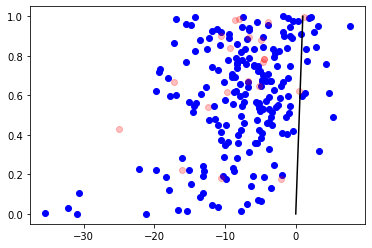

In [ ]:
plt.scatter(lambdaRanker.predict(xPUVal[~yPUVal.ravel().astype(bool)]),dg.pn_posterior_cc(xPUVal[~yPUVal.ravel().astype(bool)]),color="blue")
plt.scatter(lambdaRanker.predict(xPUVal[yPUVal.ravel().astype(bool)]),dg.pn_posterior_cc(xPUVal[yPUVal.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")

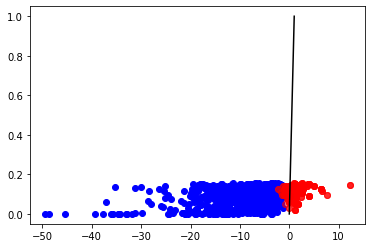

In [ ]:
plt.scatter(lambdaRanker.predict(xPUTrain[~yPUTrain.ravel().astype(bool)]),dg.pu_posterior(xPUTrain[~yPUTrain.ravel().astype(bool)]),color="blue")
plt.scatter(lambdaRanker.predict(xPUTrain[yPUTrain.ravel().astype(bool)]),dg.pu_posterior(xPUTrain[yPUTrain.ravel().astype(bool)]),color="red",alpha=.25)
plt.plot([0,1],[0,1],color="black")